In [1]:
import tensorflow as tf
import os
from PIL import Image
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


class UNetUpscaling(models.Model):

    def __init__(self,  **kwargs):

        super(UNetUpscaling, self).__init__(**kwargs)

        self.unit1 = tf.keras.Sequential([
            layers.Conv2D(32, 3, padding='same'),
            layers.ReLU(),
            layers.Conv2D(32, 3, padding='same'),
            layers.ReLU(),
            layers.Conv2DTranspose(32, 2, strides=2, padding='same')
        ])

        self.unit2 = tf.keras.Sequential([
            layers.Conv2D(16, 3, padding='same'),
            layers.ReLU(),
            layers.Conv2D(16, 3, padding='same'),
            layers.ReLU(),
            layers.Conv2DTranspose(16, 2, strides=2, padding='same')
        ])

        self.unit3 = tf.keras.Sequential([
            layers.Conv2D(3, 3, strides=2, padding='same'),
            layers.ReLU()
        ])

    def call(self, inputs):
        x1 = self.unit1(inputs)
        x2 = self.unit2(x1)
        x3 = self.unit3(x2)
        return x3

2024-05-01 17:27:10.049549: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-01 17:27:10.078049: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 17:27:10.078072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 17:27:10.078698: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 17:27:10.083481: I tensorflow/core/platform/cpu_feature_guar

In [2]:
data_path = './data/minibatch'
HR_path = os.path.join(data_path, 'HR')
LR_path = os.path.join(data_path, 'LR')

INPUT_SHAPE = (None, 50, 50, 3)
NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 0.001
TRAIN_TEST_SPLIT = 0.8
SEED = 42

def hr_to_lr(hr_name):
    """
    000001_patch_0000.png to 000001x2_patch_0000.png
    """
    hr_name = hr_name.split('_')
    hr_name[0] += 'x2'
    return '_'.join(hr_name)

def load_and_preprocess_image(x_path, y_path):
    def load_image(file_path):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
    return load_image(x_path), load_image(y_path)

hr_files = os.listdir(HR_path)
lr_files = [hr_to_lr(_) for _ in hr_files]

hr_files = [os.path.join(HR_path, _) for _ in hr_files]
lr_files = [os.path.join(LR_path, _) for _ in lr_files]

split_idx = int(len(hr_files) * TRAIN_TEST_SPLIT)
train_lr_files, train_hr_files = lr_files[:split_idx], hr_files[:split_idx]
test_lr_files, test_hr_files = lr_files[split_idx:], hr_files[split_idx:]

train_ds= tf.data.Dataset.from_tensor_slices((train_lr_files, train_hr_files))
test_ds = tf.data.Dataset.from_tensor_slices((test_lr_files, test_hr_files))

train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

tf.random.set_seed(SEED)
train_ds = train_ds.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

2024-05-01 17:27:11.858032: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-01 17:27:11.881564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-01 17:27:11.881741: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

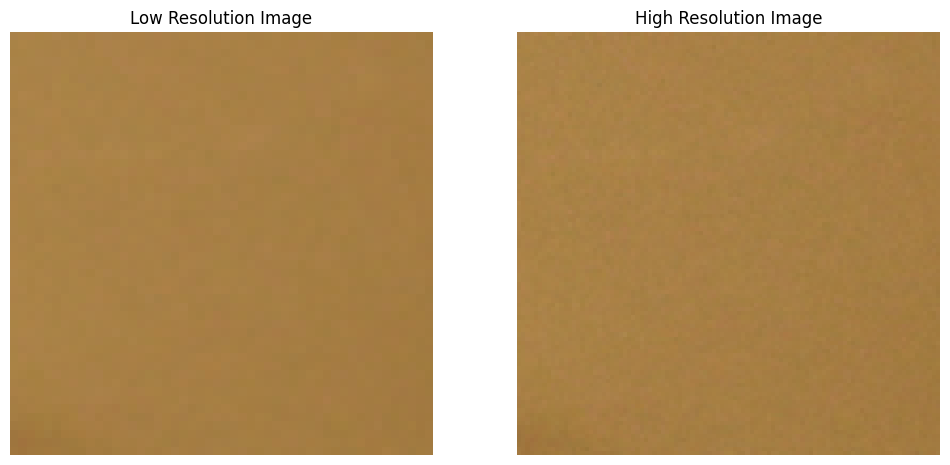

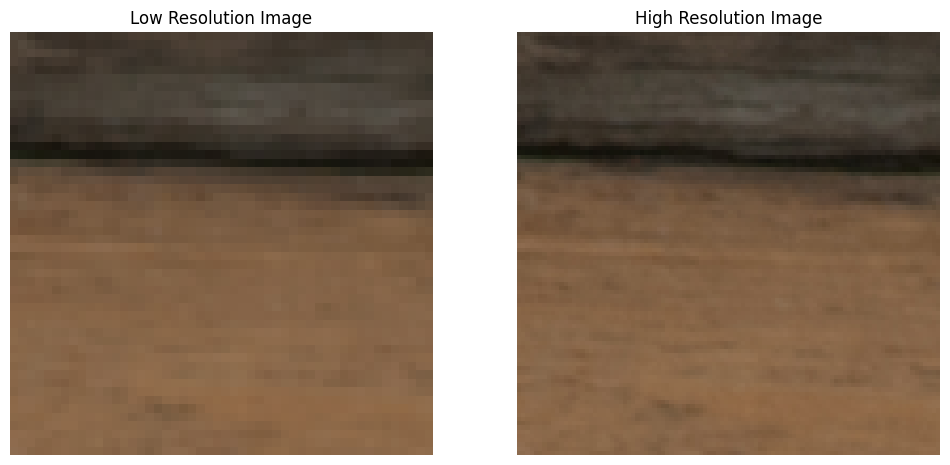

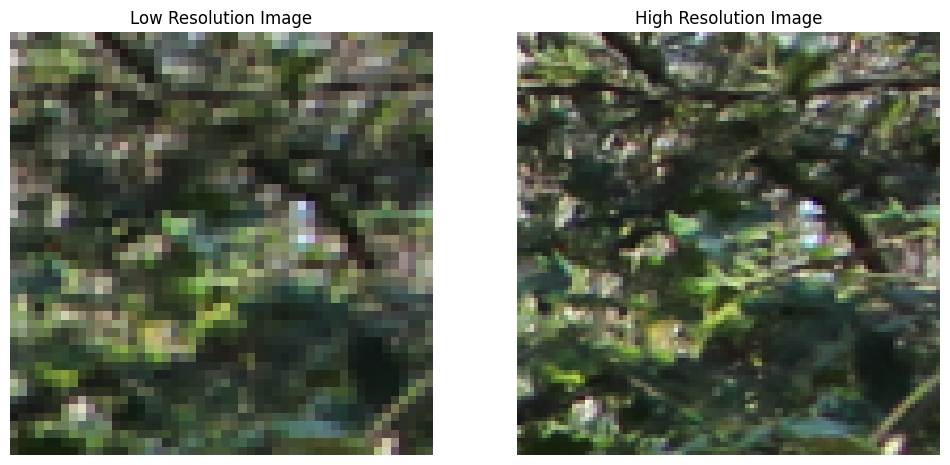

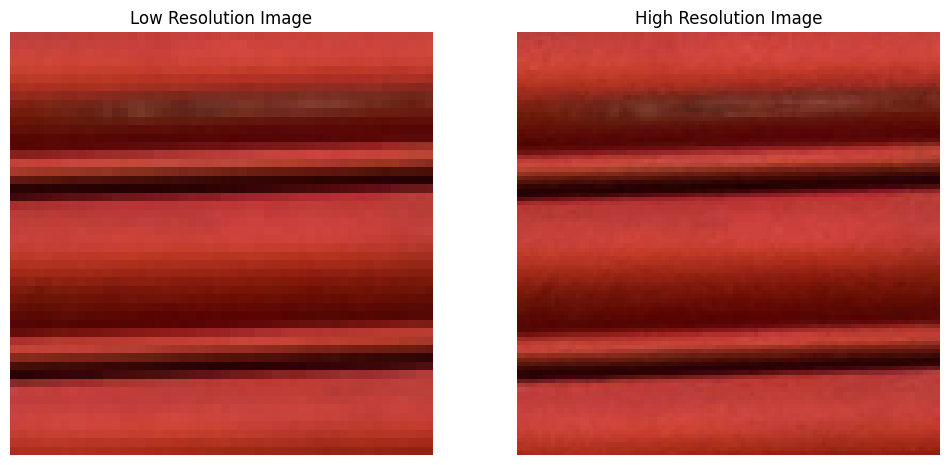

In [3]:
for lr_images, hr_images in train_ds.take(4):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title('Low Resolution Image')
    plt.imshow(lr_images[0])
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('High Resolution Image')
    plt.imshow(hr_images[0])
    plt.axis('off')
    
    plt.show()

In [4]:
model = UNetUpscaling()
model.compile(optimizer='adam', loss='mean_squared_error')
model.build(input_shape=INPUT_SHAPE)
print(model.summary())
model.fit(train_ds, epochs=NUM_EPOCHS, validation_data=test_ds)

Model: "u_net_upscaling"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 100, 100, 32)      14272     
                                                                 
 sequential_1 (Sequential)   (None, 200, 200, 16)      7984      
                                                                 
 sequential_2 (Sequential)   (None, 100, 100, 3)       435       
                                                                 
Total params: 22691 (88.64 KB)
Trainable params: 22691 (88.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/5


2024-05-01 17:27:14.481028: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-01 17:27:15.708307: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f77a627d680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-01 17:27:15.708336: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-05-01 17:27:15.711776: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714598835.785183   48468 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6575/6575 [==============================] - 208s 31ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 2/5
6575/6575 [==============================] - 202s 31ms/step - loss: 0.0011 - val_loss: 9.9427e-04
Epoch 3/5
6575/6575 [==============================] - 204s 31ms/step - loss: 0.0010 - val_loss: 9.6283e-04
Epoch 4/5
6575/6575 [==============================] - 268s 41ms/step - loss: 9.7239e-04 - val_loss: 9.5122e-04
Epoch 5/5
6575/6575 [==============================] - 227s 35ms/step - loss: 9.5566e-04 - val_loss: 9.4807e-04


In [5]:
a = iter(test_ds)

x_samples, y_samples = next(a)
y_pred = model.predict(x_samples)
y_pred = tf.clip_by_value(y_pred, 0, 1)

1/1 [==============================] - 0s 305ms/step


/tmp/ipykernel_47585/1578373123.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


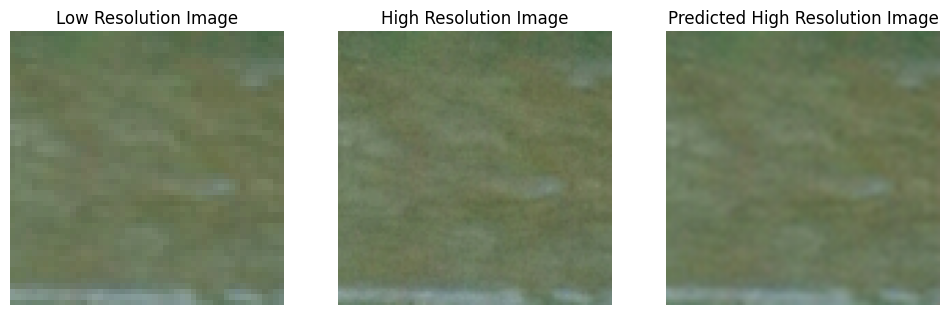

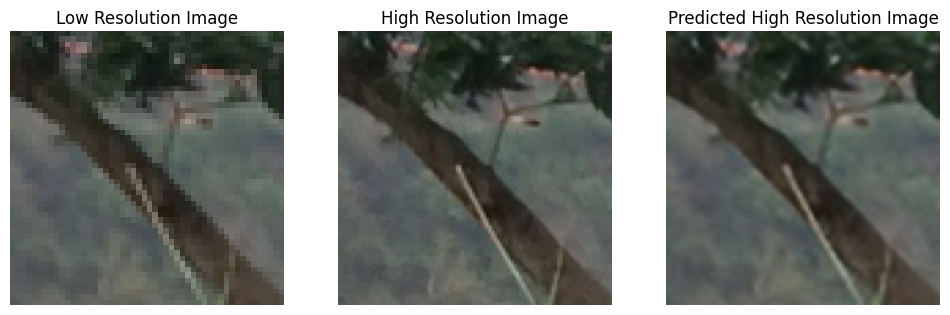

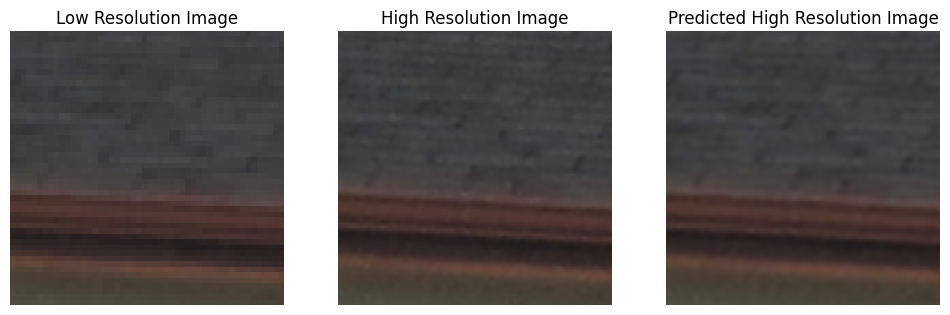

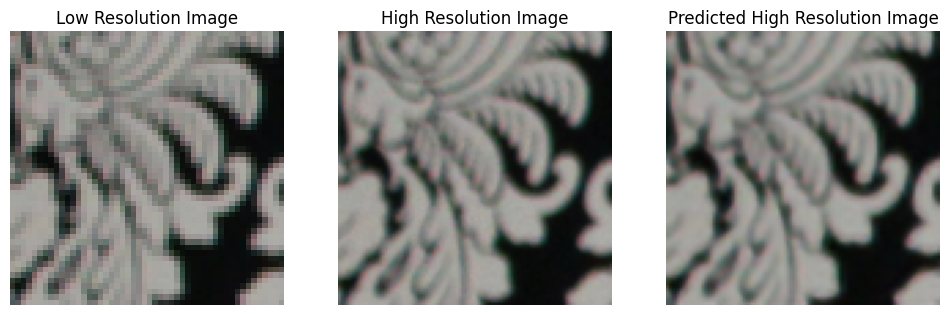

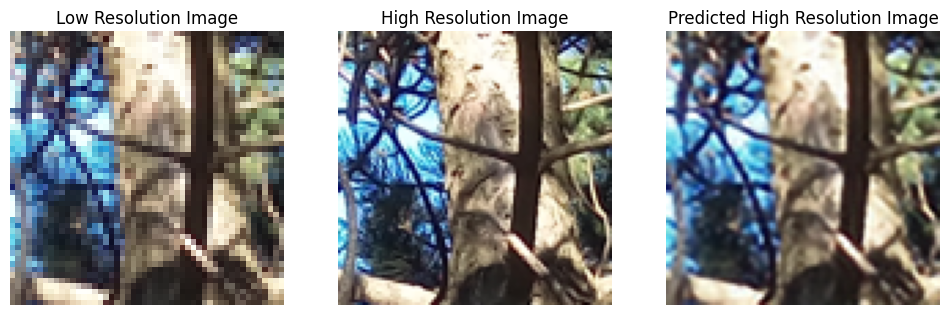

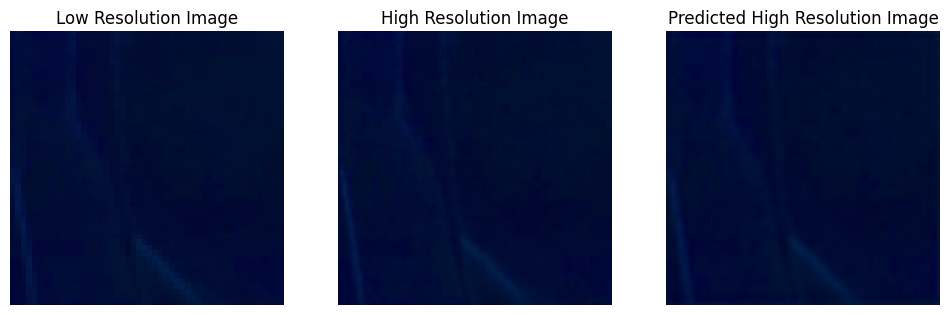

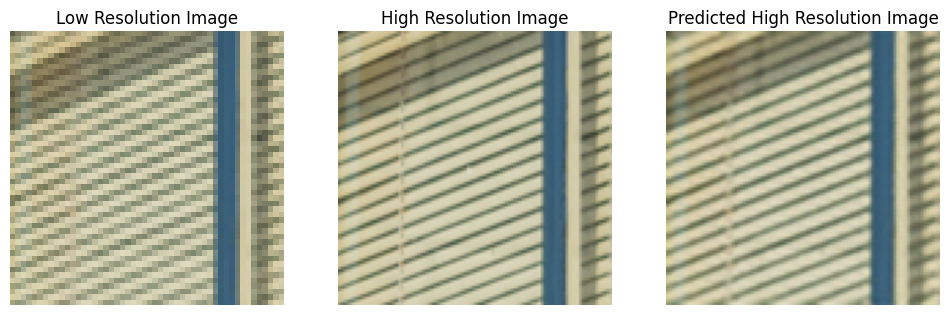

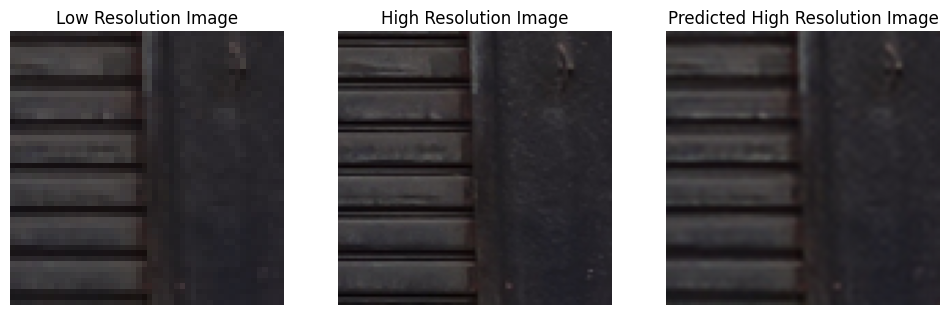

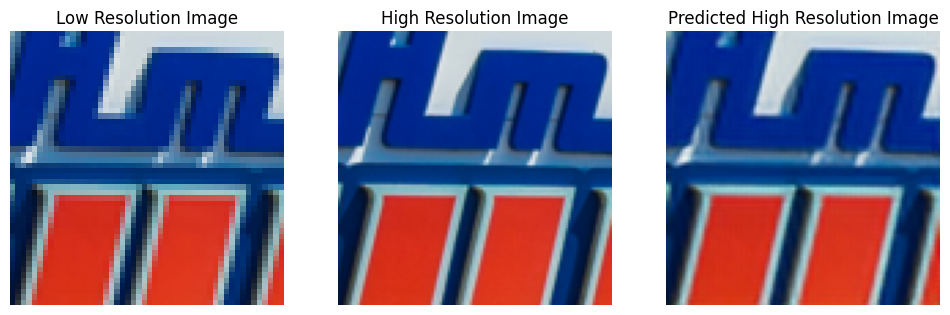

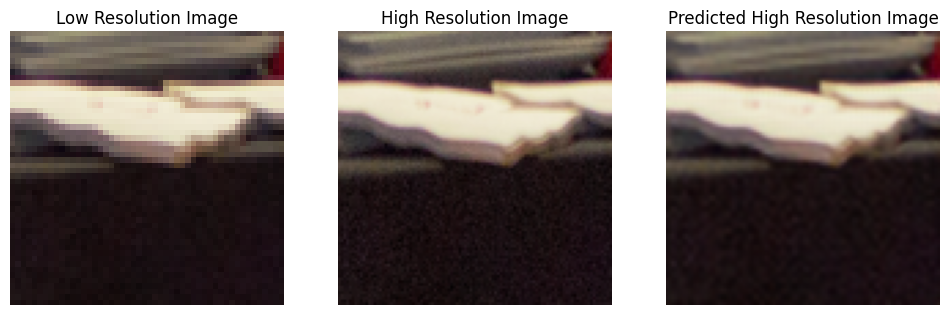

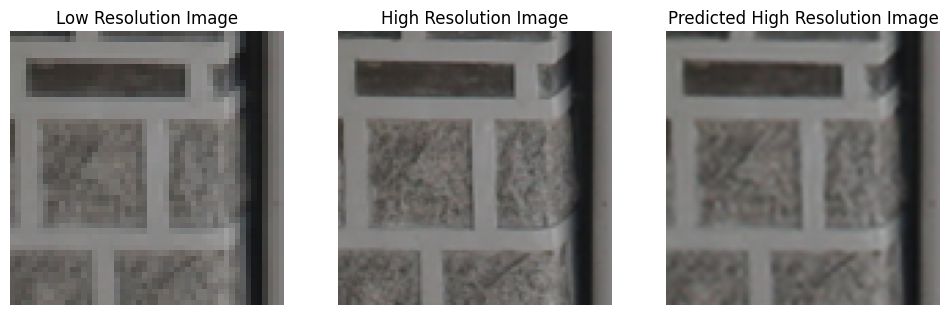

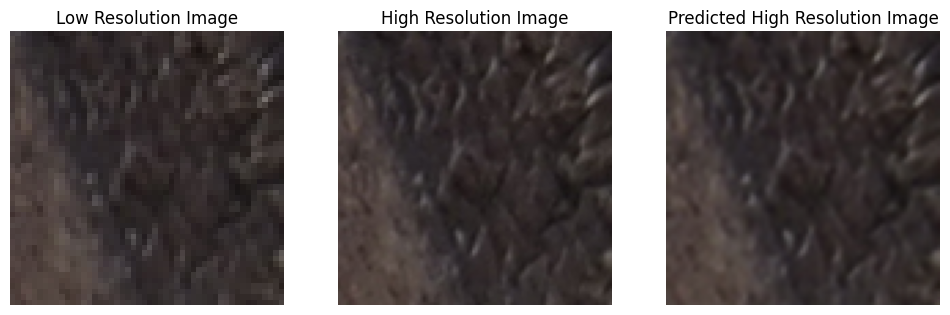

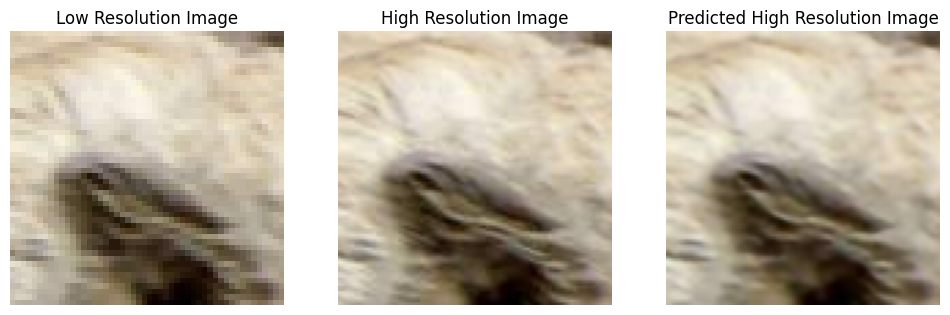

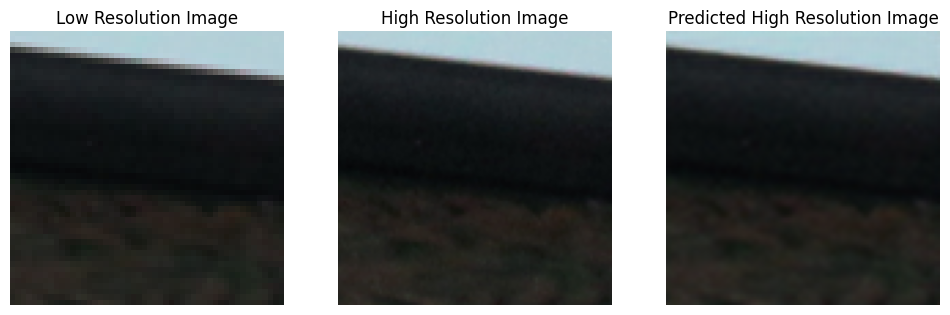

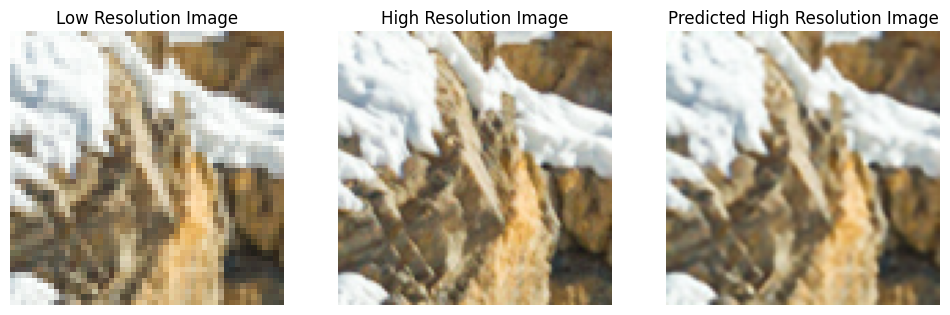

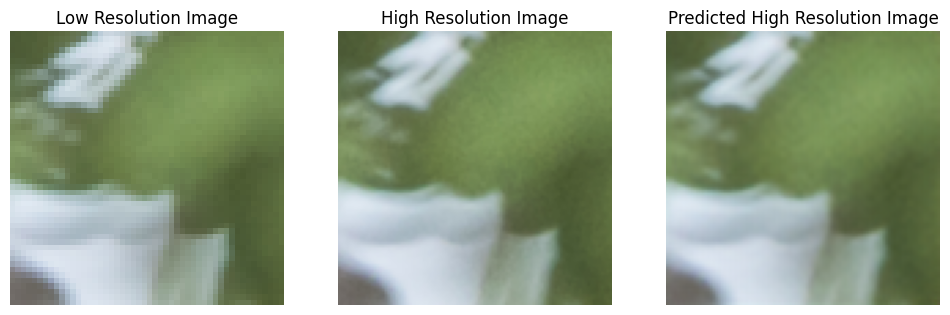

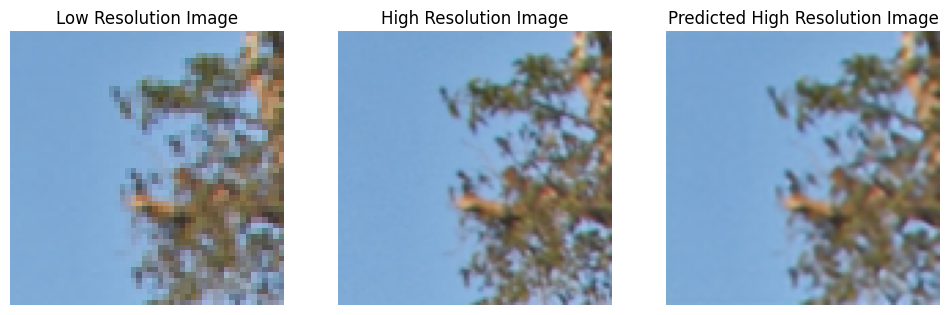

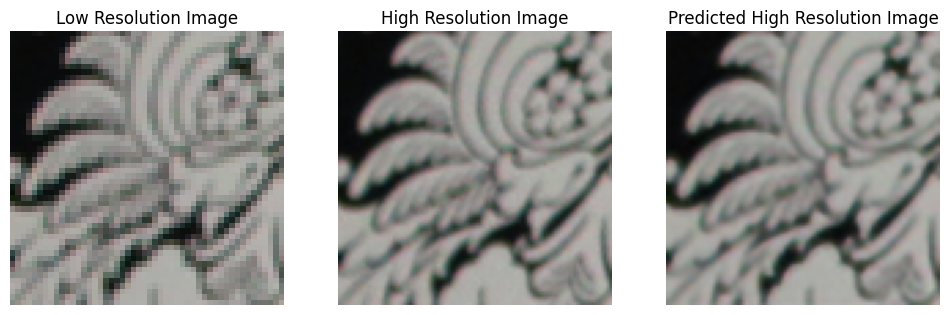

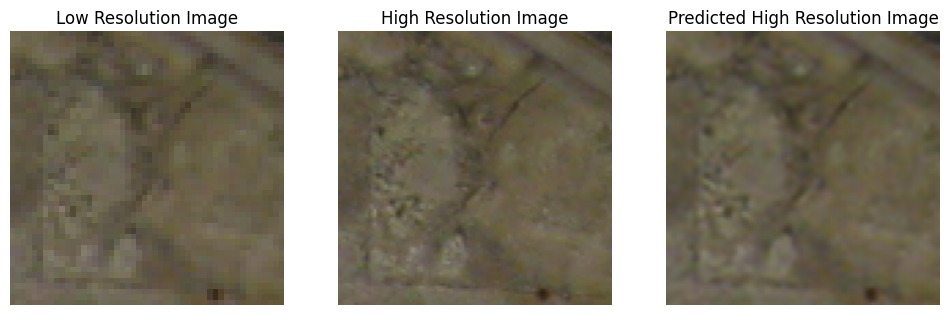

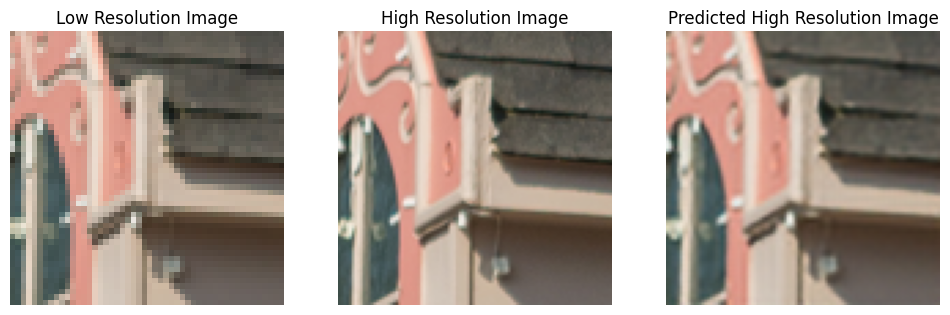

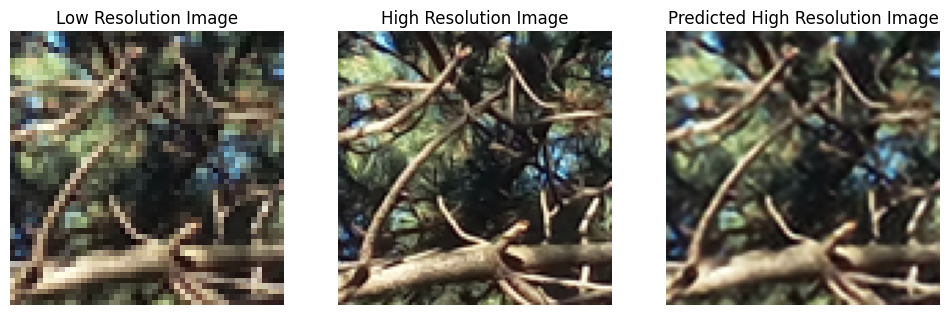

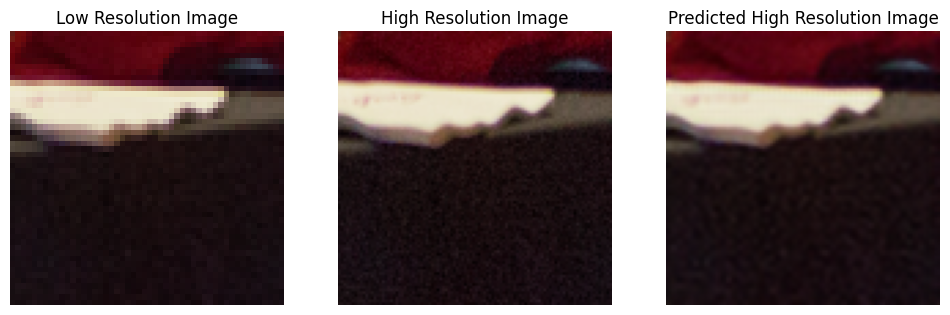

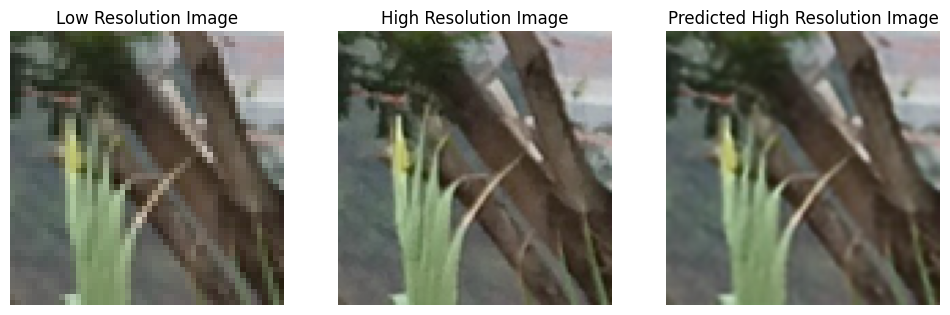

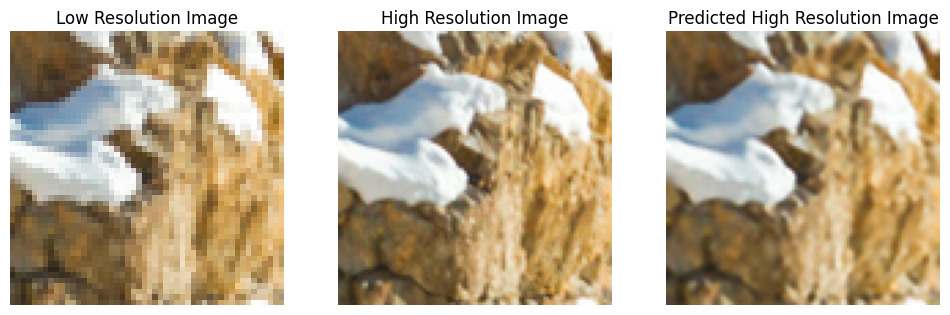

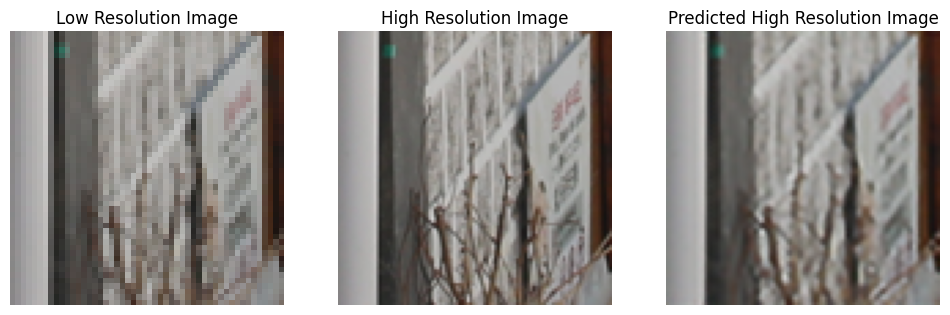

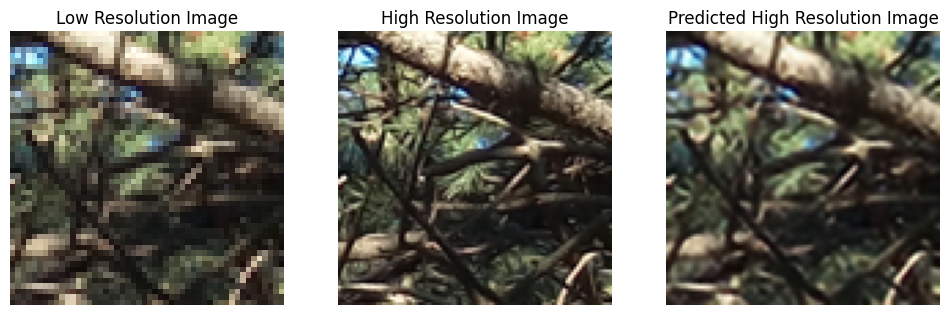

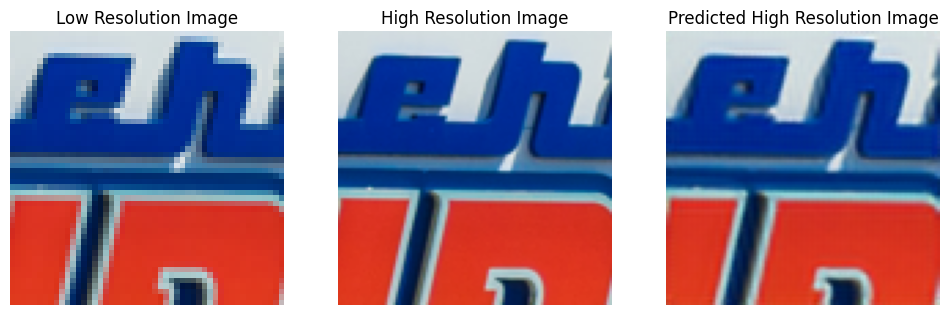

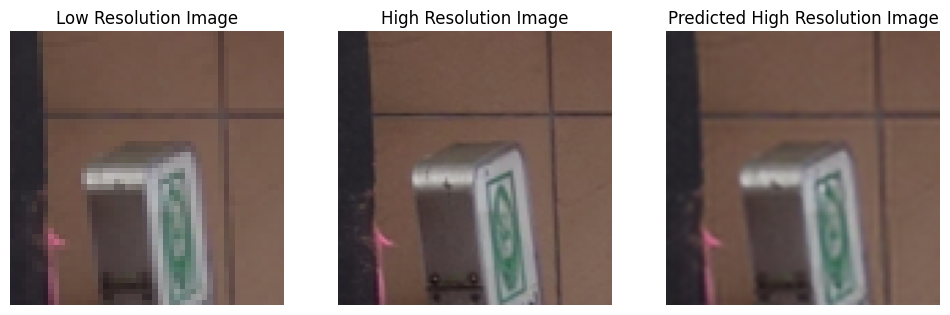

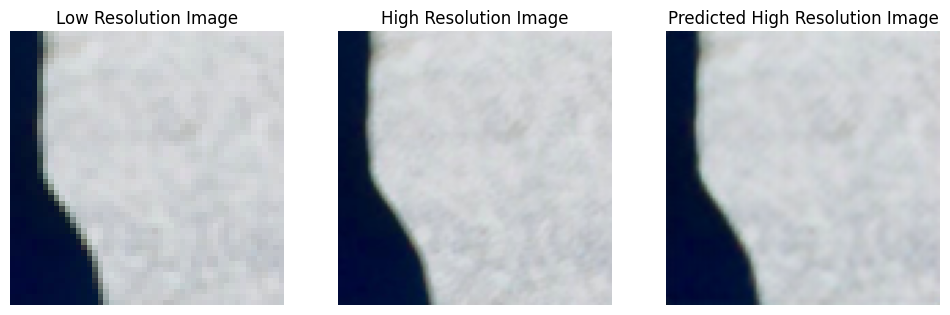

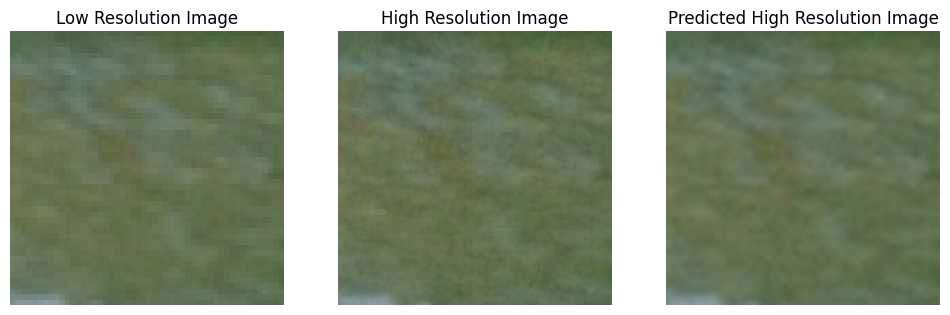

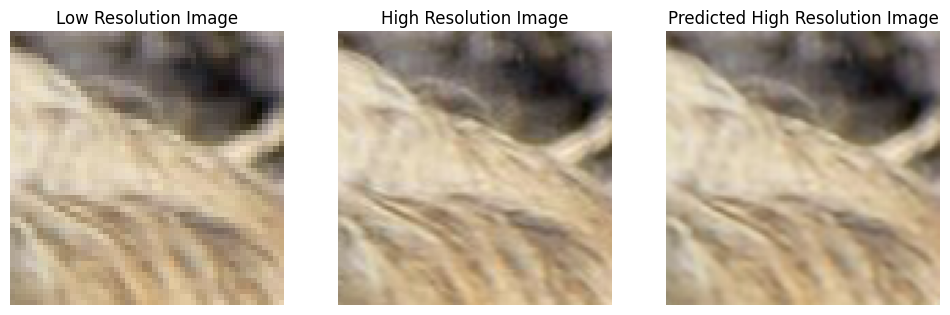

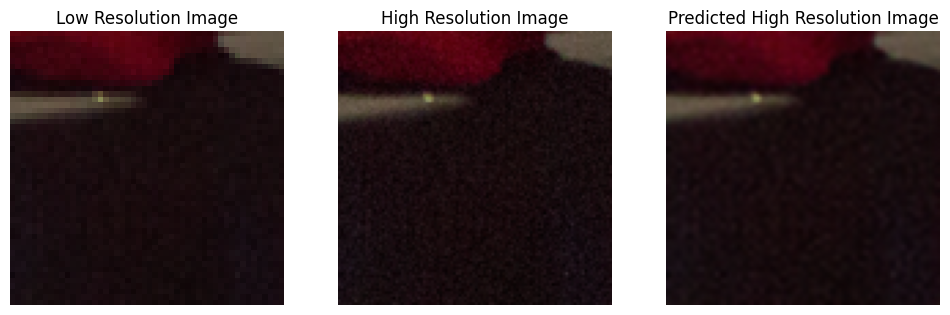

In [6]:
for i in range(BATCH_SIZE):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Low Resolution Image')
    plt.imshow(x_samples[i])
    plt.axis('off')


    plt.subplot(1, 3, 2)
    plt.title('High Resolution Image')
    plt.imshow(y_samples[i])
    plt.axis('off')


    plt.subplot(1, 3, 3)
    plt.title('Predicted High Resolution Image')
    plt.imshow(y_pred[i])
    plt.axis('off')

In [7]:
# save model to disk
model.save('unet_upscaling')

INFO:tensorflow:Assets written to: unet_upscaling/assets


INFO:tensorflow:Assets written to: unet_upscaling/assets
